In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import numpy as np

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import seaborn as sns
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
import quandl as q
token="Us3wFmXGgAj_1cUtHAAR"

In [4]:
sp=q.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken=token).Value

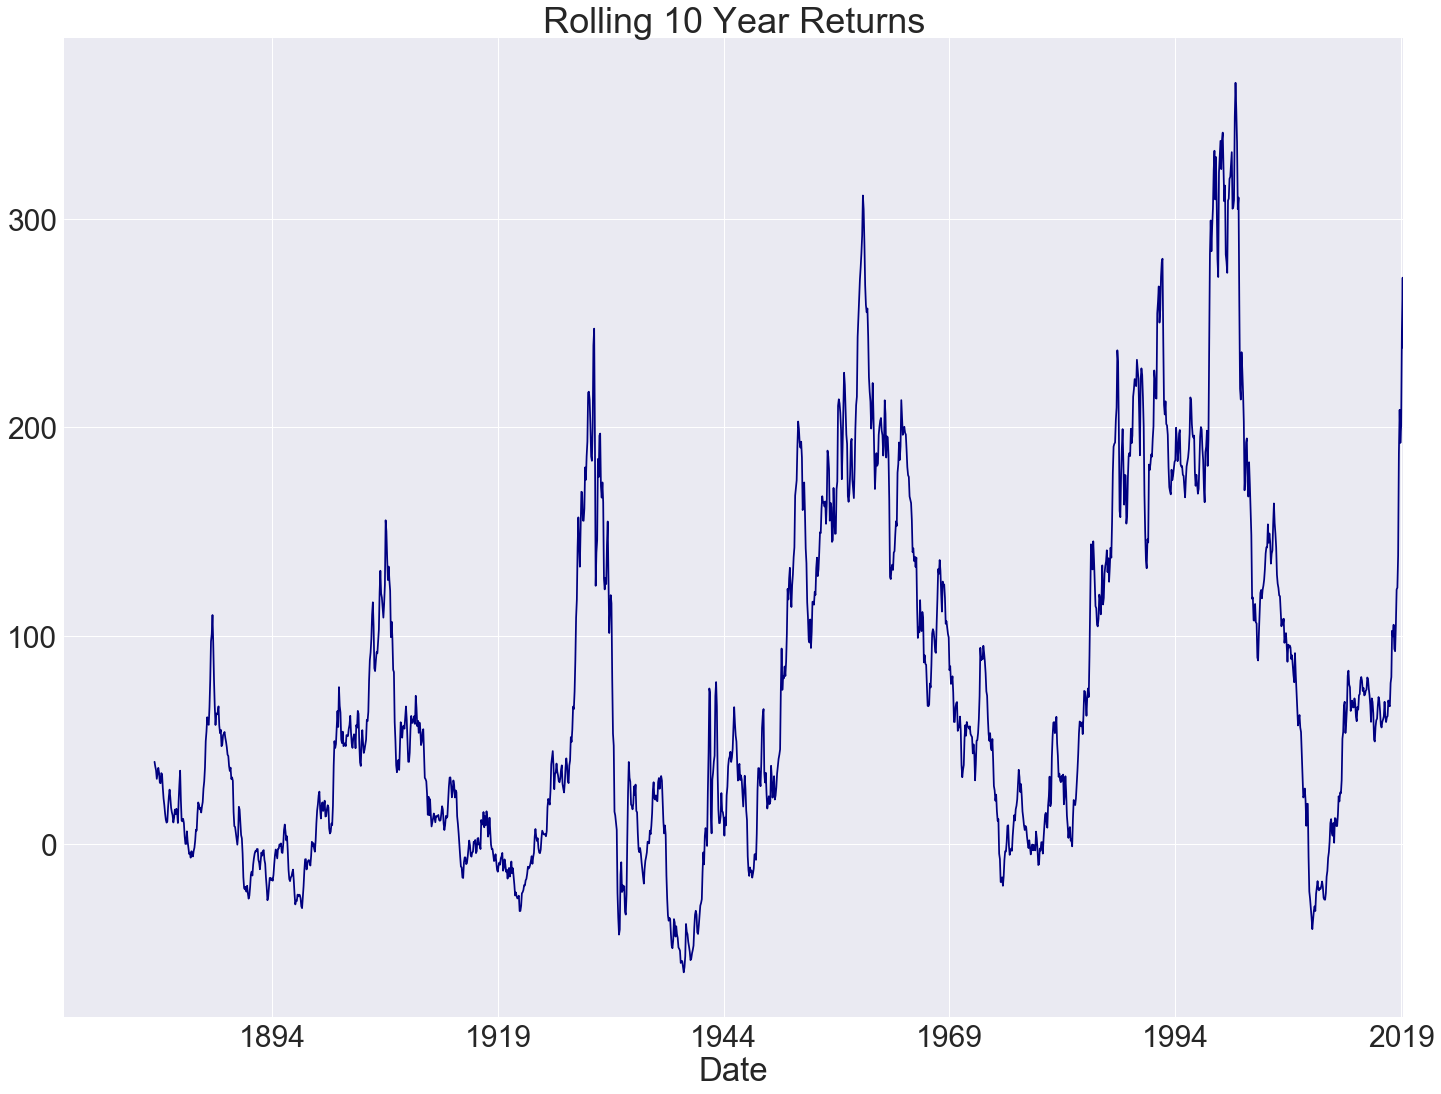

In [198]:
(sp.pct_change(120)*100).plot(colormap='jet',title='Rolling 10 Year Returns')

In [180]:
roll=(sp.pct_change(120)*100).dropna()

In [181]:
roll[roll<0].count()/roll.count()

0.19879518072289157

In [187]:
roll2=roll['1919':]
roll2[roll2<0].count()/roll2.count()

0.1669435215946844

In [188]:
roll[roll<0].min()

-61.661129568106318

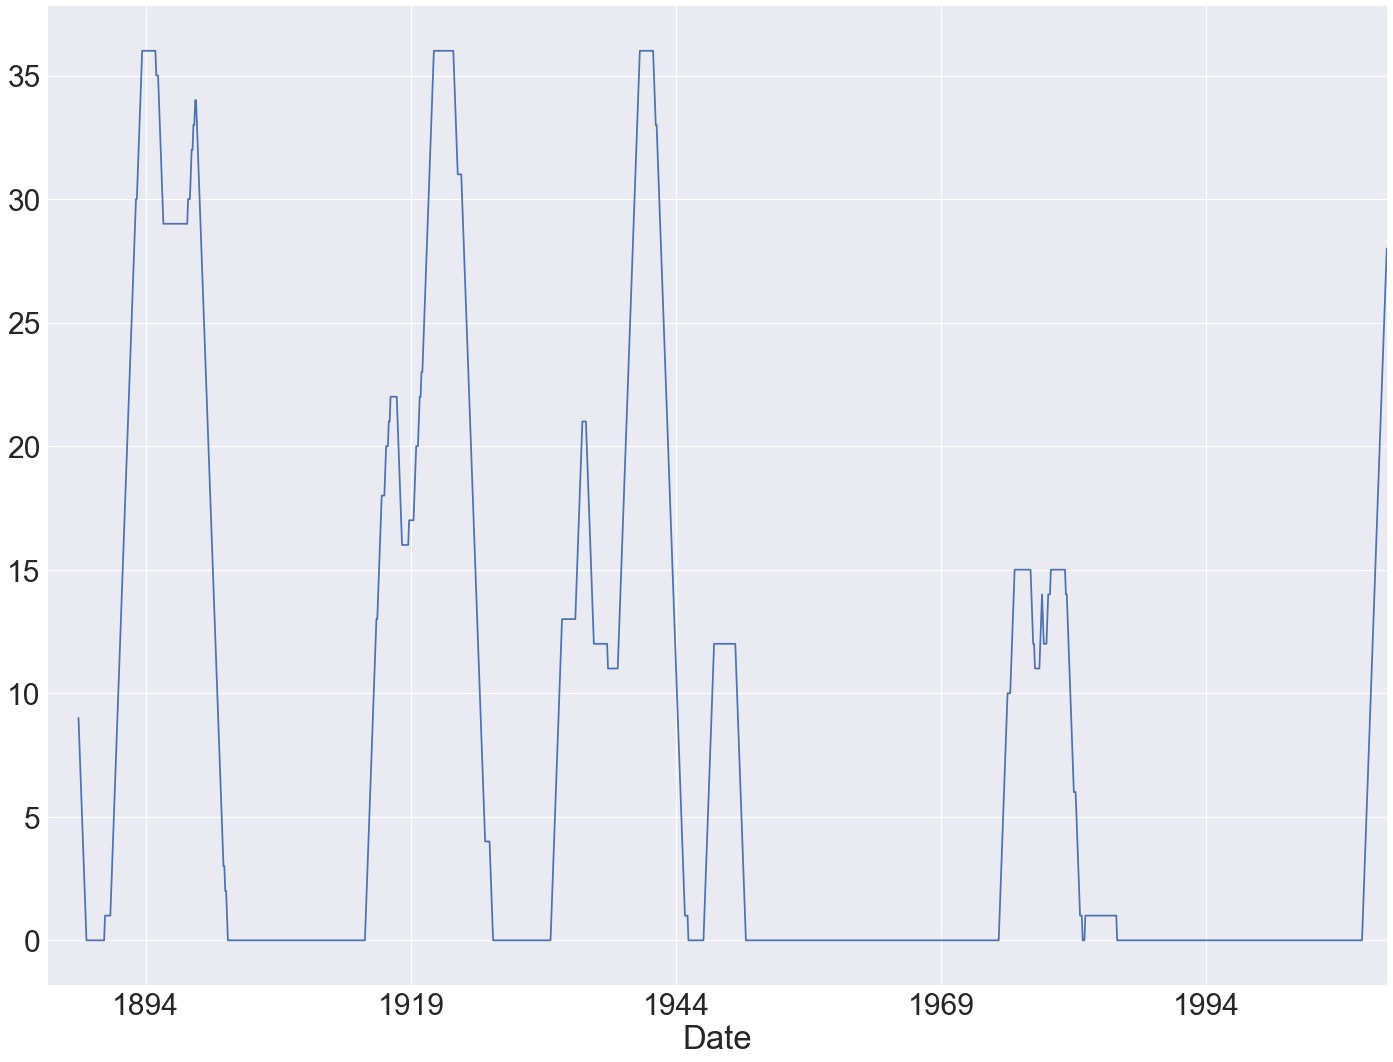

In [229]:
c=roll[roll<0].resample(rule='m').count()
c.rolling(36).sum().plot()

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1000000,min_periods=1,center=False).max()
  """Entry point for launching an IPython kernel.


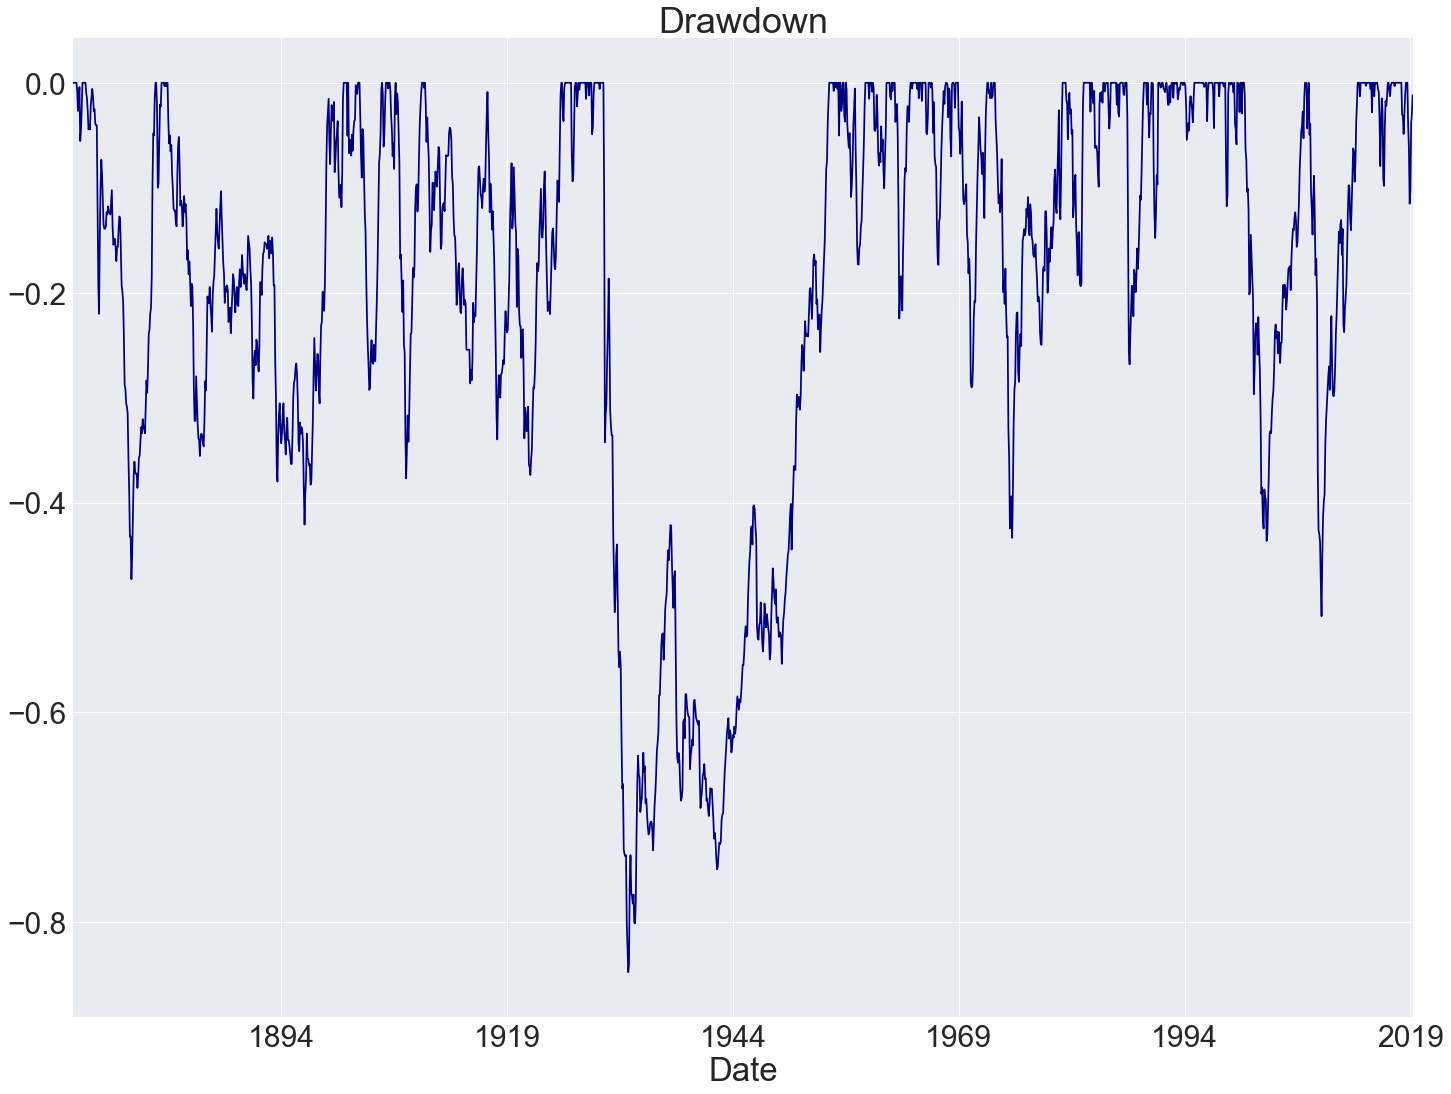

In [194]:
(sp/pd.rolling_max(sp,1000000,min_periods=1)-1).plot(colormap='jet',title='Drawdown of SP')

In [197]:
5/32

0.15625

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2fbe50f0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c2fbf00f0>], dtype=object)

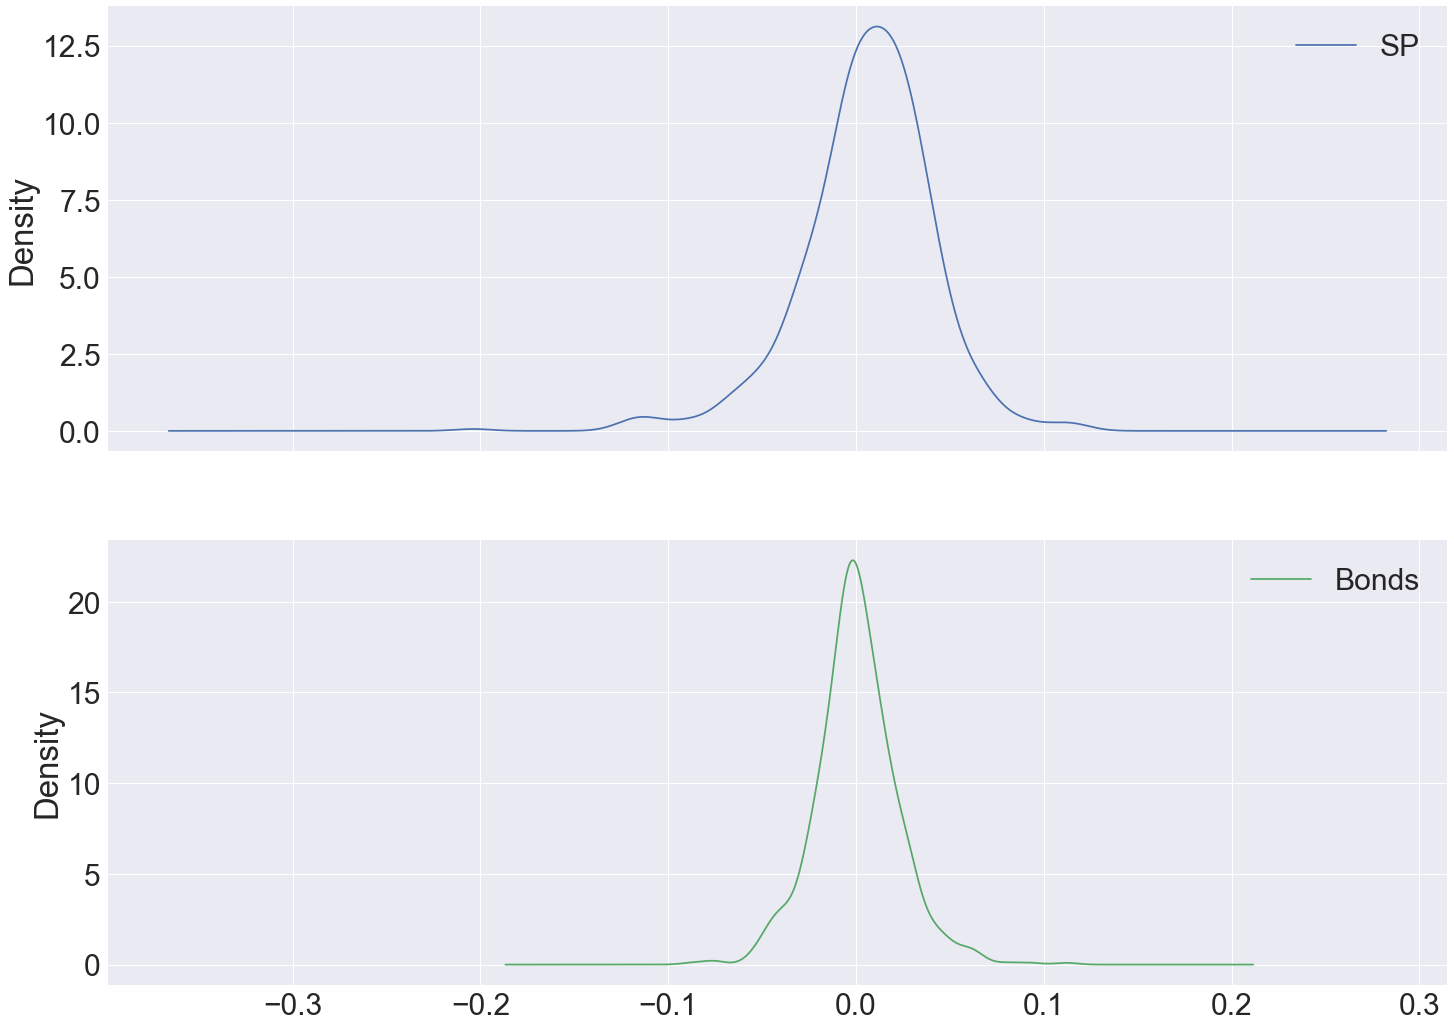

In [207]:
df.plot(kind='kde',subplots=True)

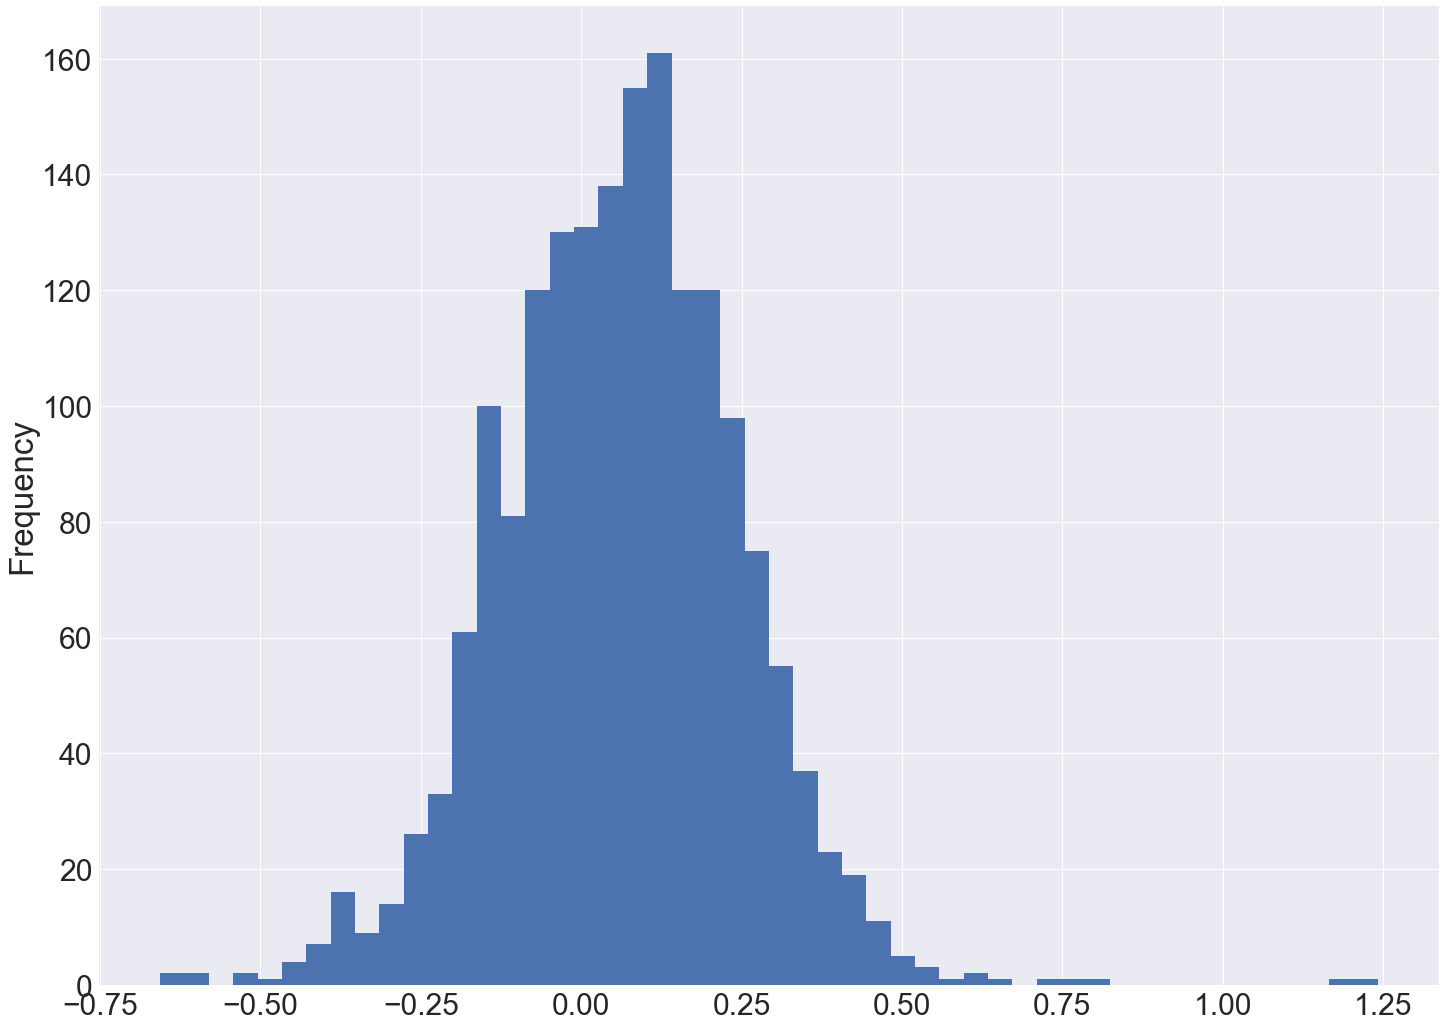

In [204]:
sp.pct_change(12).plot(kind='hist',bins=50)

In [8]:
yld=q.get("FRED/DGS10", authtoken=token).Value

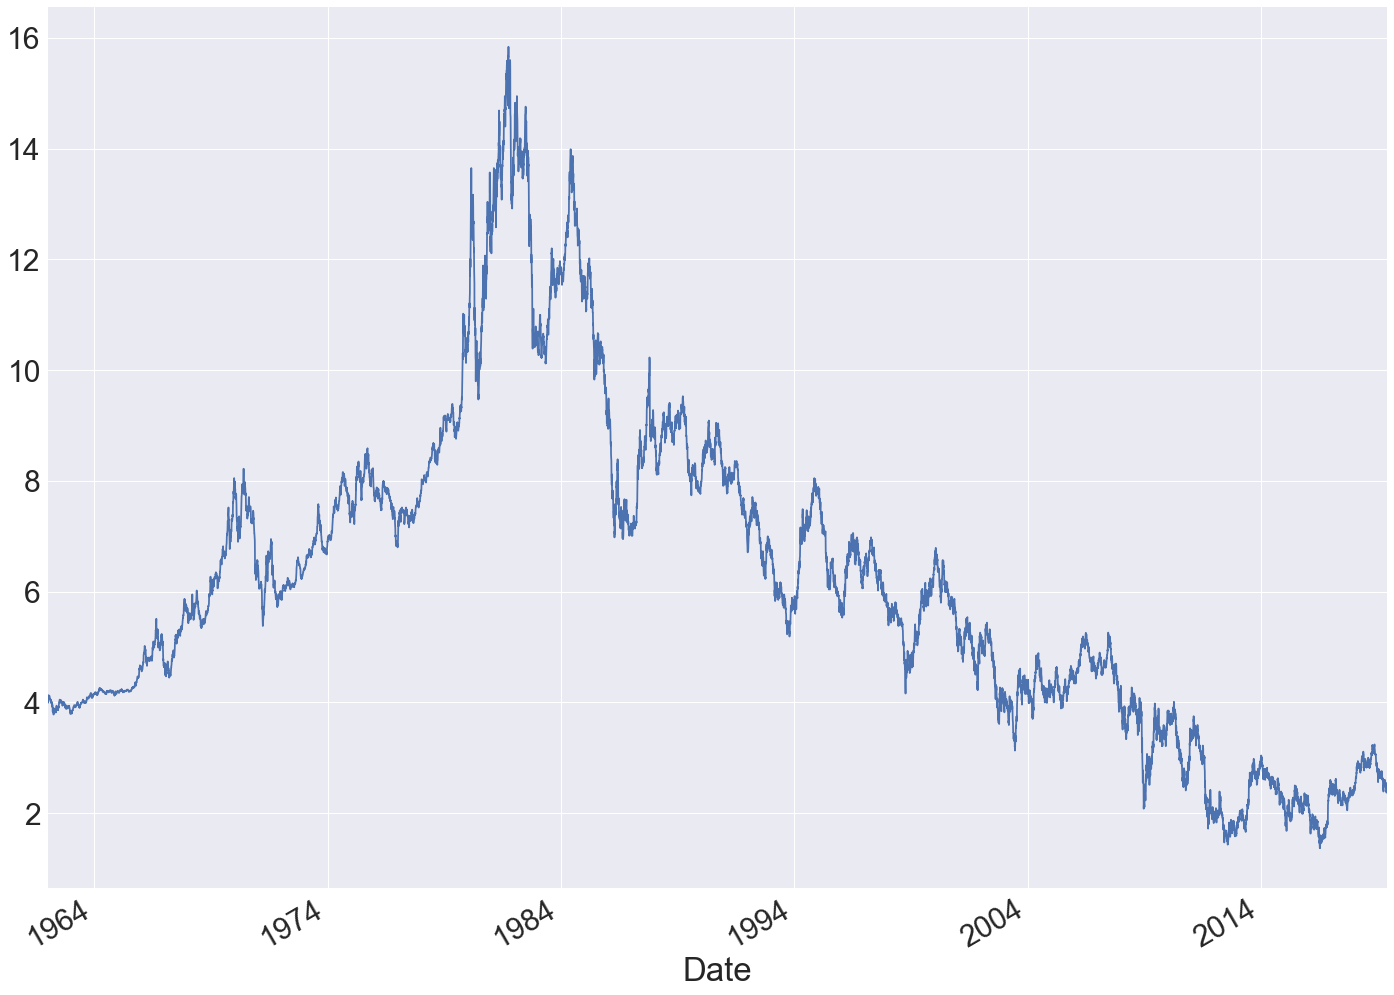

In [9]:
yld.plot()

In [10]:
def yields_to_rtn_index(yld):
    s = pd.Series()
    last=4.06
    for timestamp,yi in yld.iteritems():
        interest = yi/1200.
        np.pv(0.0403,10,4.06,fv=100)
        change=np.pv(yi/100.,10,-last,fv=-100)-100
        last=yi
        s[timestamp]=change+interest
    return s

In [11]:
bd_rtn=yields_to_rtn_index(yld.resample(rule='m').last())

In [12]:
df = pd.DataFrame()
df['SP']=sp.resample(rule='m').last().pct_change()
df['Bonds']=bd_rtn.resample(rule='m').last()/100
df=df.dropna()

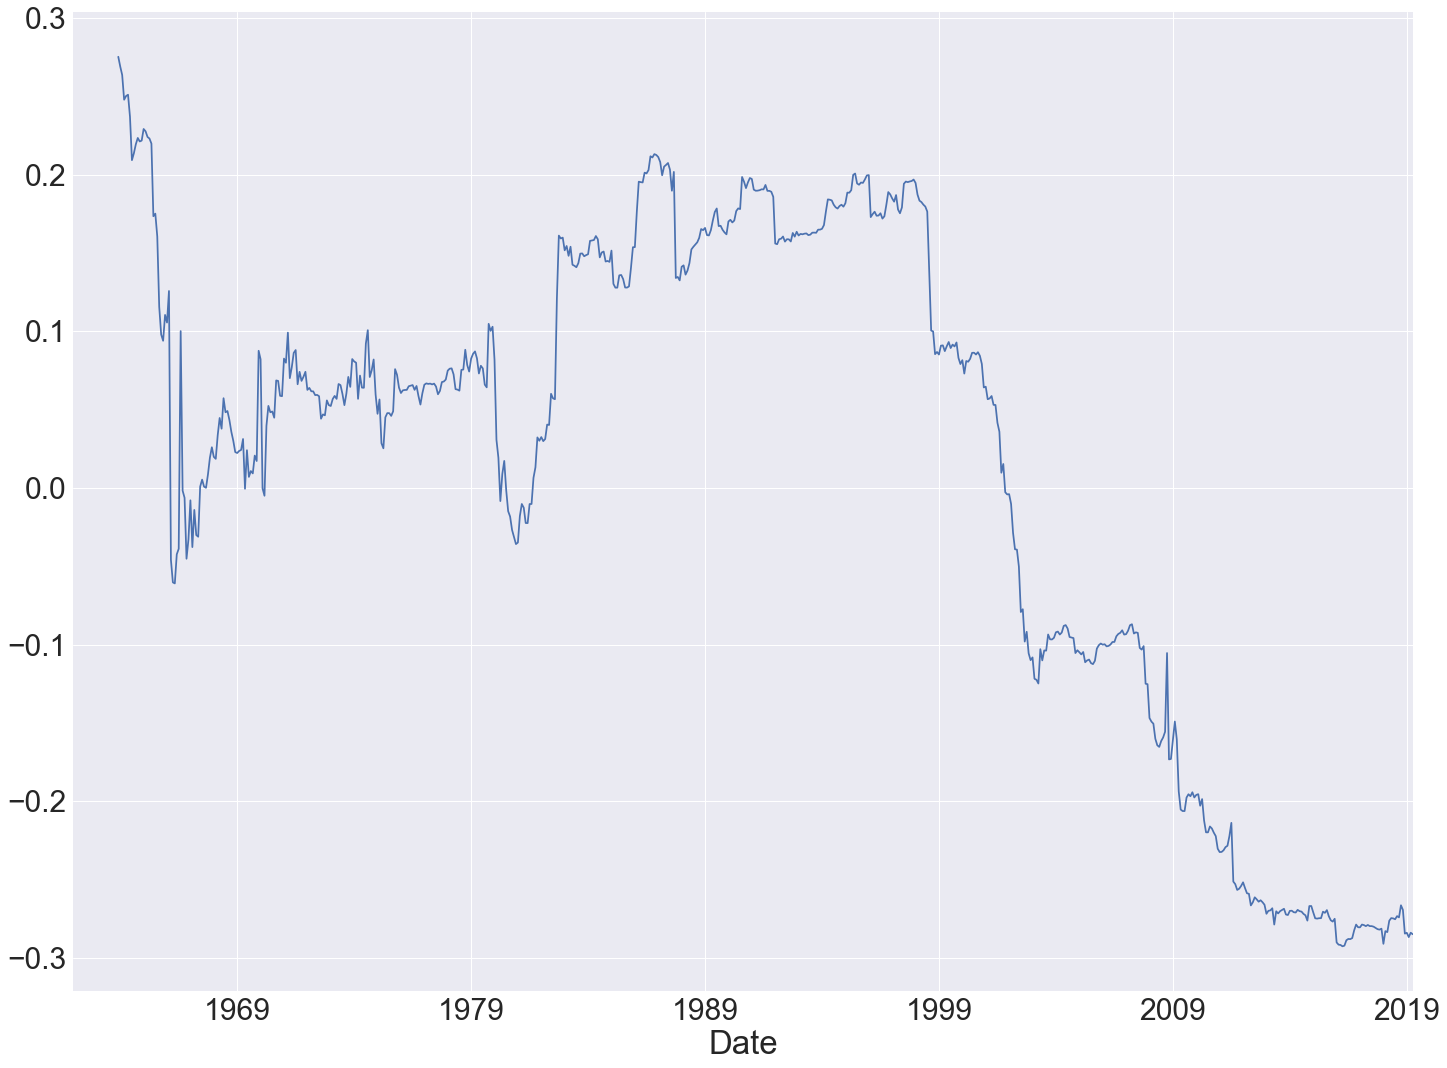

In [19]:
df.SP.ewm(120,min_periods=24).corr(df.Bonds).plot()

In [22]:
inf=q.get("RATEINF/INFLATION_USA", authtoken=token).Value

In [208]:
df2=pd.DataFrame()
df2['Stock Bond Correlation']=df.SP.rolling(120,min_periods=48).corr(df.Bonds)
df2['US Inflation']=pd.Series.rolling(inf,36).mean()

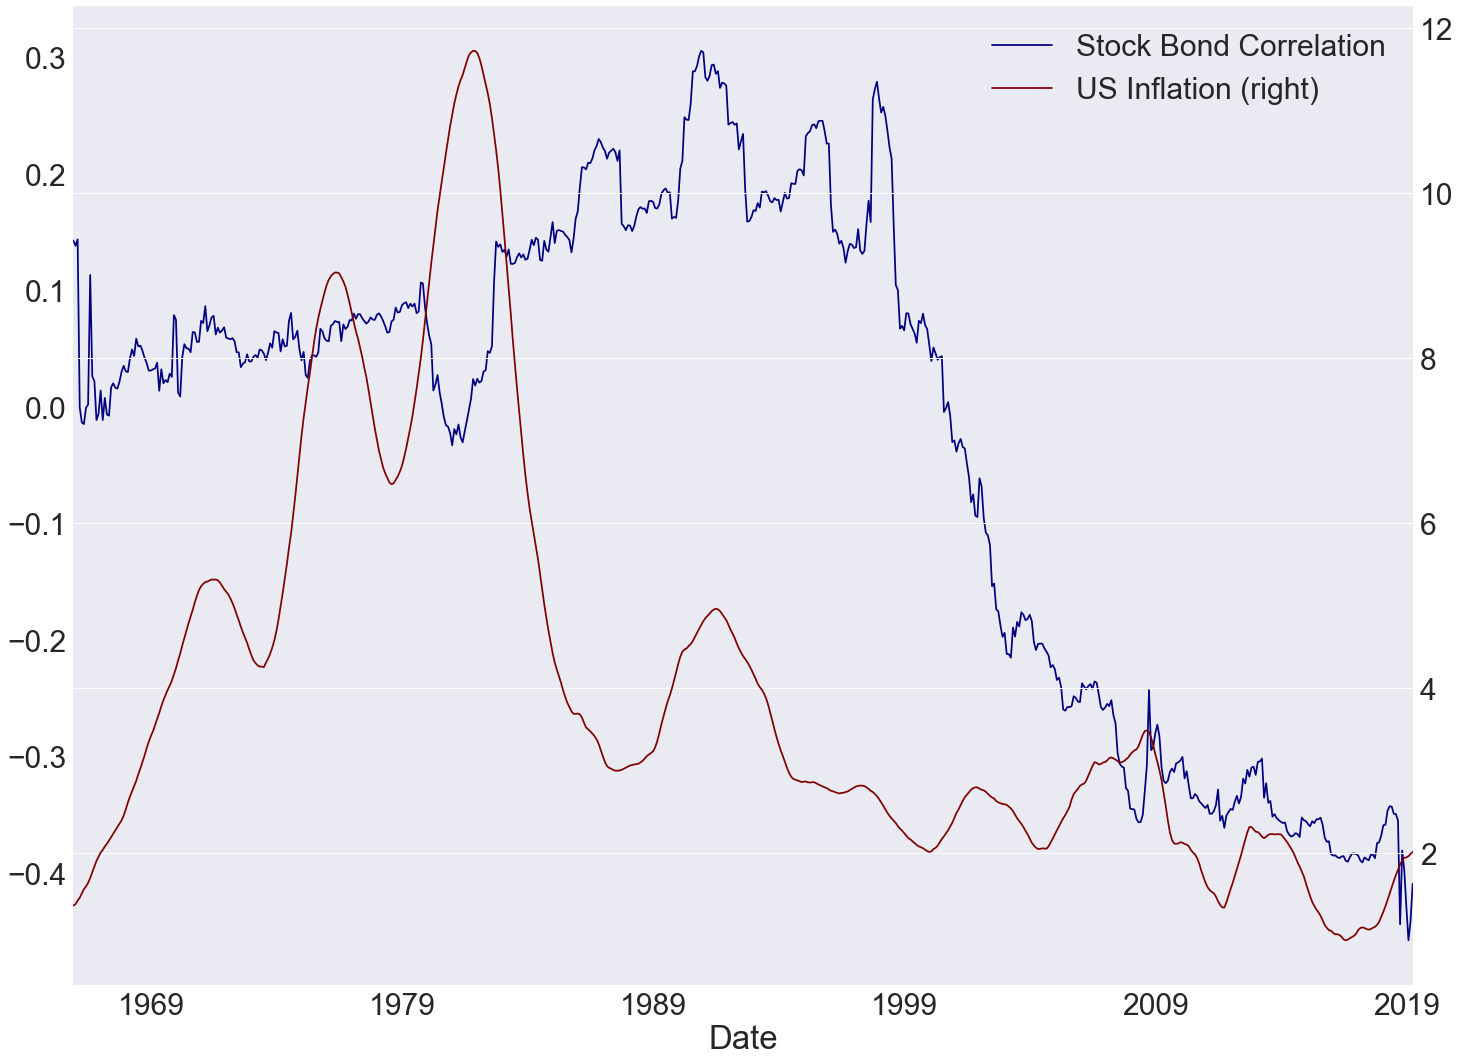

In [209]:
df2.dropna().plot(secondary_y='US Inflation',colormap='jet')

In [68]:
w=pd.Series({'SP':0.6,'Bonds':.4})
portfolios= df.multiply(w).sum(axis=1)

In [159]:
sb_corr=df.SP.rolling(24,min_periods=24).corr(df.Bonds)

In [160]:
above = sb_corr[sb_corr>sb_corr.median()].index
below = sb_corr[sb_corr<sb_corr.median()].index

In [161]:
calc_Sharpe(portfolios[below])

KeyError: "DatetimeIndex(['1964-06-30', '1964-07-31', '1964-08-31', '1964-09-30',\n               '1964-11-30', '1964-12-31', '1965-01-31', '1965-02-28',\n               '1965-03-31', '1965-04-30',\n               ...\n               '2018-02-28', '2018-03-31', '2018-04-30', '2018-07-31',\n               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',\n               '2019-03-31', '2019-04-30'],\n              dtype='datetime64[ns]', name='Date', length=332, freq=None) not in index"

In [169]:
import math
portfolios[below].std()*math.sqrt(12)

KeyError: "DatetimeIndex(['1964-06-30', '1964-07-31', '1964-08-31', '1964-09-30',\n               '1964-11-30', '1964-12-31', '1965-01-31', '1965-02-28',\n               '1965-03-31', '1965-04-30',\n               ...\n               '2018-02-28', '2018-03-31', '2018-04-30', '2018-07-31',\n               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',\n               '2019-03-31', '2019-04-30'],\n              dtype='datetime64[ns]', name='Date', length=332, freq=None) not in index"

,RP,60/40
Date,,


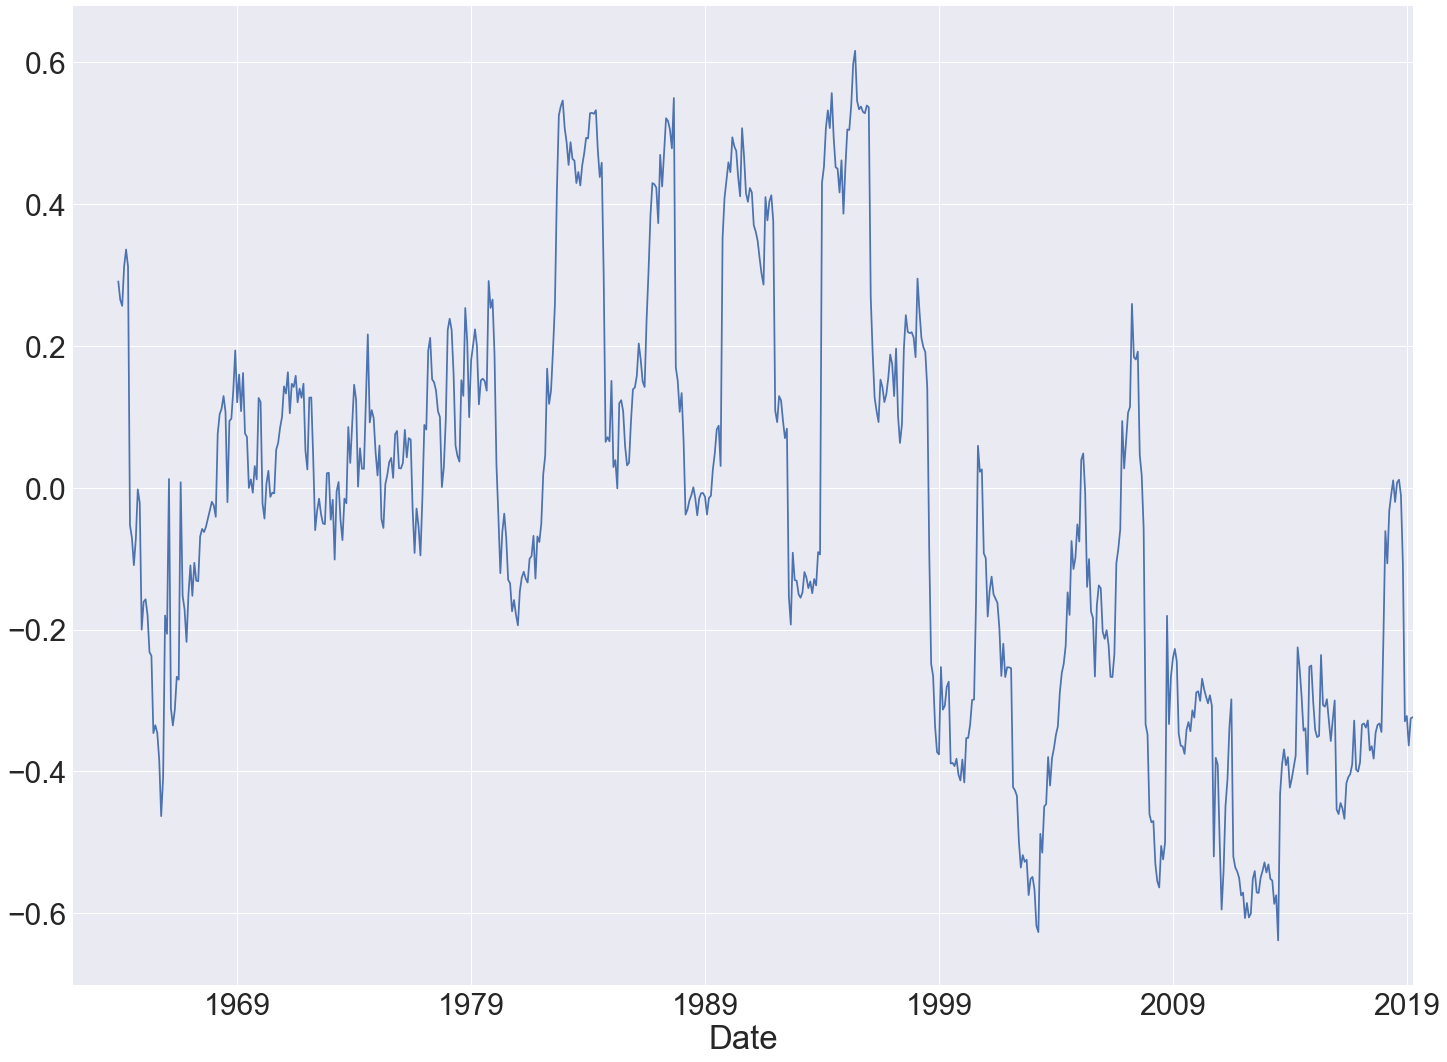

In [111]:
sb_corr.plot()

#  Quick findings

*  Increased correlation means of course increased volatility in portfolios
*  

In [154]:
sf=portfolios.std()/1.4492


In [167]:
portfolios=pd.DataFrame()
portfolios['RP']=((df/pd.rolling_std(df,24)).dropna().sum(axis=1)*sf)
portfolios['60/40']=df.multiply(w).sum(axis=1)

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).std()
  


In [89]:
def calc_Sharpe(pnl,N=12):
    return np.sqrt(N) * pnl.mean() / pnl.std()

In [120]:
df.cumsum().tail()

,SP,Bonds
Date,,
2018-12-31,4.018239,0.259975
2019-01-31,4.031966,0.265213
2019-02-28,4.104568,0.256587
2019-03-31,4.113144,0.284744
2019-04-30,4.131542,0.276017


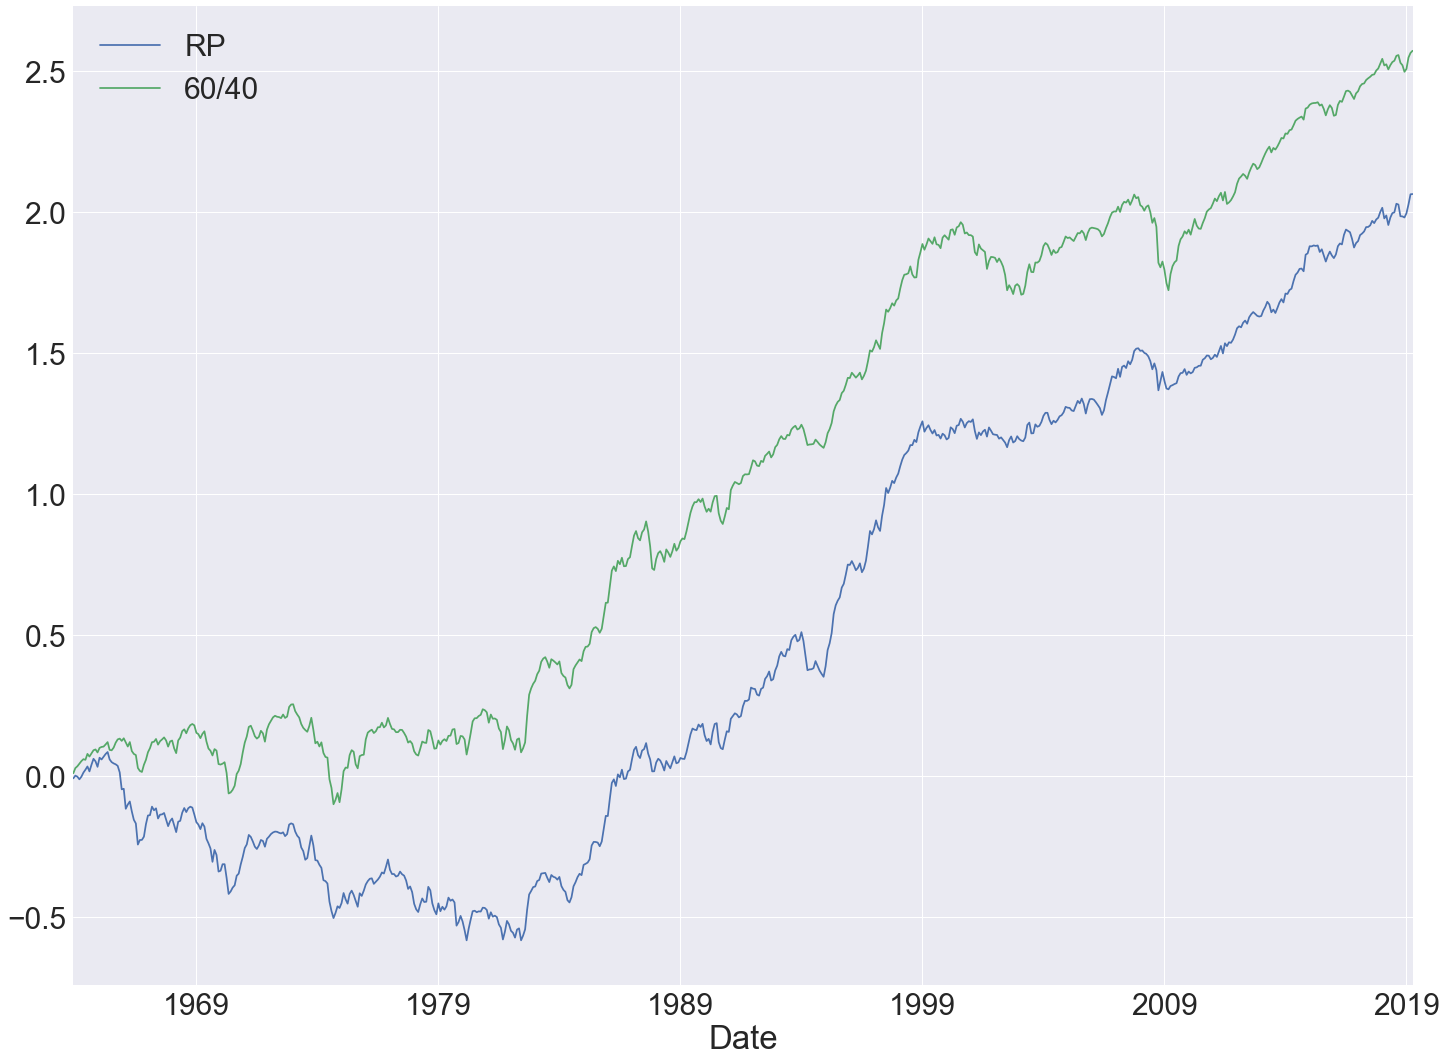

In [172]:
portfolios.cumsum().plot()

# U / V shape recovery versus flat returns

In [57]:
a=[[0.00,0],
    [0.01,-0.30],
  [0.01,0.10],
   [0.01,0.10],
   [0.01,0.10],
  [0.01,0.10],]

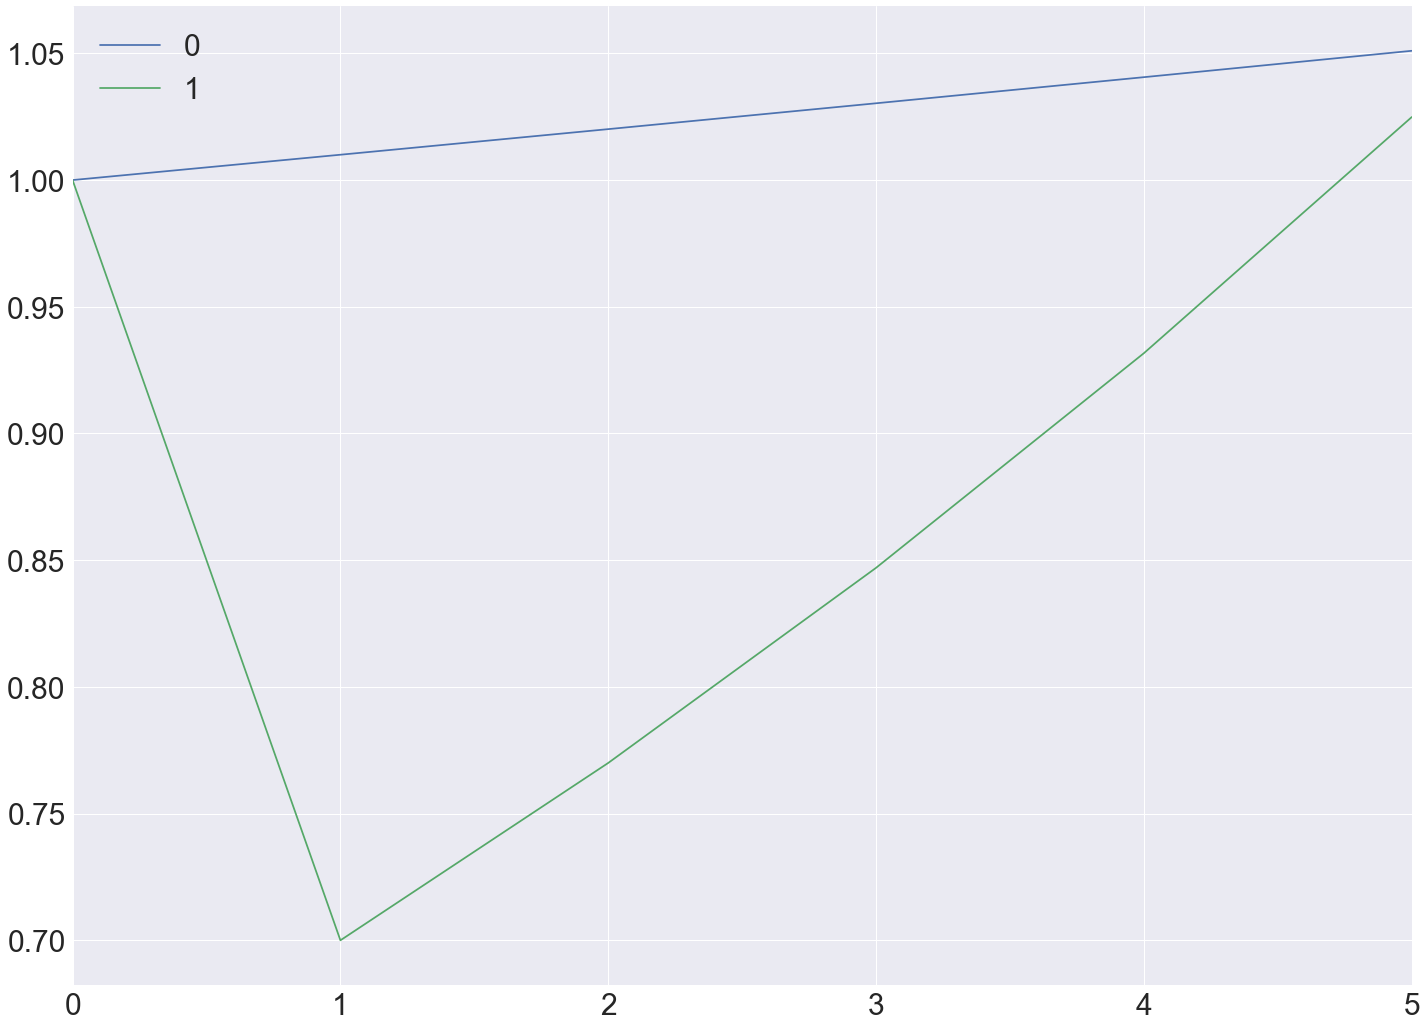

In [58]:
(pd.DataFrame(a)+1).cumprod().plot()